<a href="https://colab.research.google.com/github/chesyaivana/Kel.04_sysrec/blob/main/CCN_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.  Load and Preprocess Data
mengimpor semua library yang diperlukan untuk analisis sentimen. Library seperti pandas, numpy, dan matplotlib digunakan untuk manipulasi data dan visualisasi. Library Keras digunakan untuk membangun model CNN. nltk digunakan untuk preprocessing teks, termasuk penghapusan stopword.

In [63]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import nltk
from nltk.corpus import stopwords

memuat dataset, membersihkan kolom yang tidak relevan, menghapus entri NaN pada kolom Reviews, dan memproses teks dengan fungsi preprocess_text yang membersihkan teks dari karakter khusus, mengubahnya menjadi huruf kecil, serta menghapus stopword.

In [64]:
# Load dataset
data = pd.read_csv("Tempat-Wisata-Toba-Preprocessing.csv")

# Rename columns for clarity
data = data.rename(columns={'ReviewerId': 'user_id', 'PlaceID': 'item_id', 'Rating': 'rating', 'Reviews': 'text'})

# Data type conversion
data['user_id'] = data['user_id'].astype(str)
data['item_id'] = data['item_id'].astype(str)
data['rating'] = data['rating'].astype(float)

# Drop irrelevant columns
data = data.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, errors='ignore') # Ignore if columns don't exist
# Text Preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())  # Remove punctuation and lowercase
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

data['processed_text'] = data['text'].apply(preprocess_text)  # Store in a new column

# Label Encoding (Sentiment Classification)
data['sentiment'] = data['rating'].apply(lambda x: 2 if x >= 4 else (1 if x == 3 else 0))
# 2: positive, 1: neutral, 0: negative

# Tokenization and Padding
max_words = 5000  # Adjust as needed
max_len = 100     # Adjust as needed

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(data['processed_text'])
sequences = tokenizer.texts_to_sequences(data['processed_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Prepare data for CNN
X = padded_sequences
y = to_categorical(data['sentiment'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
# Apply preprocessing
data['text'] = data['text'].apply(preprocess_text)

In [66]:
data.head()

,address,item_id,Nama_tempat_wisata,Category,user_id,rating,text,processed_text,sentiment
0,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.12603e+20,5.0,nan,nan,2
1,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.11909e+20,5.0,bagus,bagus,2
2,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.07886e+20,5.0,nan,nan,2
3,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.13072e+20,5.0,menyenagkan,menyenagkan,2
4,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.06173e+20,5.0,bebas foto dimana aja k,bebas foto dimana aja k,2


# 2. Label Encoding


mengubah kolom Rating menjadi label sentimen (positif, netral, negatif) berdasarkan skala rating. LabelEncoder digunakan untuk mengonversi label sentimen menjadi angka, dan to_categorical mengubah label tersebut menjadi representasi one-hot untuk digunakan dalam pelatihan model.

In [67]:
# Label encoding for sentiment (you might need to manually classify the sentiment)
data['Sentiment'] = data['rating'].apply(lambda x: 'positive' if x >= 4 else ('neutral' if x == 3 else 'negative'))
label_encoder = LabelEncoder()
data['Sentiment'] = label_encoder.fit_transform(data['Sentiment'])

In [68]:
y = to_categorical(data['Sentiment'])

# 3. Tokenization and Padding

menggunakan Tokenizer untuk mengubah teks menjadi urutan angka, di mana setiap angka merepresentasikan kata. Data kemudian diubah menjadi urutan dengan panjang yang seragam menggunakan pad_sequences agar dapat diproses oleh CNN.

In [69]:
# Tokenize text
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# 4. Split Data

membagi data ke dalam set pelatihan (80%) dan set pengujian (20%) untuk memastikan model diuji dengan data yang tidak terlihat selama pelatihan.

In [70]:
# Split the data into training (70%), validation (15%), and testing (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(padded_sequences, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.176, random_state=42)  # 15% of total data


## 5. Definisikan Model CNN

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

def build_cnn_model(input_dim, input_length, output_dim, embedding_dim=100, filters=128, kernel_size=5, dropout_rate=0.5):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=input_length))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Build the model
input_dim = max_words + 1  # Vocabulary size + 1 for padding token
output_dim = y_train.shape[1]  # Number of sentiment classes
model = build_cnn_model(input_dim, max_len, output_dim)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Latih Model

In [72]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,  # Adjust as needed
                    batch_size=32,  # Adjust as needed
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/10
947/947 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8750 - loss: 0.4923 - val_accuracy: 0.8800 - val_loss: 0.4209
Epoch 2/10
947/947 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8765 - loss: 0.4175 - val_accuracy: 0.8799 - val_loss: 0.4259
Epoch 3/10
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8823 - loss: 0.3860 - val_accuracy: 0.8786 - val_loss: 0.4384
Epoch 4/10
947/947 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8936 - loss: 0.3568 - val_accuracy: 0.8729 - val_loss: 0.4739


In [89]:
from tensorflow.keras.layers import Bidirectional, LSTM, BatchNormalization
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def build_advanced_model(input_dim, input_length, output_dim, params):
       model = Sequential()
       model.add(Embedding(input_dim=input_dim, output_dim=params['embedding_dim'], input_length=input_length))
       model.add(Dropout(0.2))
       model.add(Bidirectional(LSTM(128, return_sequences=True)))
       model.add(Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation='relu'))
       model.add(GlobalMaxPooling1D())
       model.add(Dense(128, activation='relu'))
       model.add(Dropout(params['dropout_rate']))
       model.add(BatchNormalization())  # Added Batch Normalization
       model.add(Dense(output_dim, activation='softmax'))
       optimizer = Adam(learning_rate=params['learning_rate'])
       model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
       return model

In [90]:
param_grid = {
       'embedding_dim': [100, 200, 300],
       'filters': [64, 128, 256],
       'kernel_size': [3, 5, 7],
       'dropout_rate': [0.2, 0.3, 0.5],
       'learning_rate': [0.001, 0.0001],
       'batch_size': [32, 64],
   }

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  >>> # multilabel classification


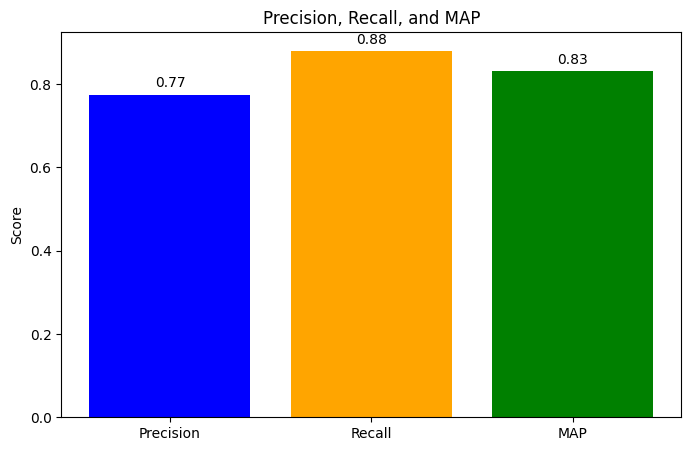

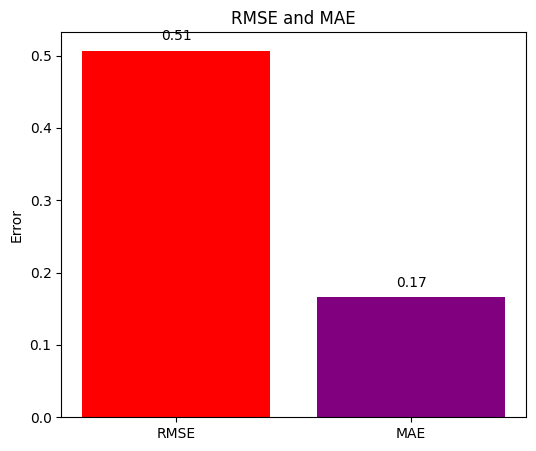

Precision: 0.77
Recall: 0.88
MAP: 0.83
RMSE: 0.51
MAE: 0.17


In [91]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, average_precision_score, mean_squared_error, mean_absolute_error

# 1. Predict on the test data
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 2. Calculate Precision, Recall, and MAP
from sklearn.metrics import precision_score, recall_score, average_precision_score

# Precision dan Recall
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')

# Mean Average Precision (MAP)
map_score = average_precision_score(y_test, y_pred_probs, average='weighted')

# 3. Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_true_classes, y_pred_classes))
mae = mean_absolute_error(y_true_classes, y_pred_classes)

# 4. Create Bar Charts

# Bar chart for Precision, Recall, and MAP
metrics = ['Precision', 'Recall', 'MAP']
values = [precision, recall, map_score]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'orange', 'green'])
plt.title('Precision, Recall, and MAP')
plt.ylabel('Score')
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
plt.show()

# Bar chart for RMSE and MAE
metrics = ['RMSE', 'MAE']
values = [rmse, mae]

plt.figure(figsize=(6, 5))
plt.bar(metrics, values, color=['red', 'purple'])
plt.title('RMSE and MAE')
plt.ylabel('Error')
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
plt.show()

# 5. Print the metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"MAP: {map_score:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

mendefinisikan arsitektur CNN dengan Embedding layer untuk mengonversi kata ke vektor numerik, Conv1D untuk ekstraksi fitur, GlobalMaxPooling1D untuk pengurangan dimensi, dan Dense layer untuk klasifikasi. Model dikompilasi dengan adam optimizer dan dilatih menggunakan data training.

# 6. Evaluasi

mengevaluasi performa model pada data pengujian dan menampilkan akurasi. Plot kurva akurasi ditampilkan untuk memantau kinerja model selama pelatihan dan validasi.

In [92]:
# Menghitung jumlah ulasan dan rata-rata rating
top_places = data.groupby('Nama_tempat_wisata').agg(
    total_reviews=('rating', 'count'),
    avg_rating=('rating', 'mean')
).sort_values(by=['avg_rating', 'total_reviews'], ascending=[False, False])  # Change sorting order

# Top-5 dan Top-10 tempat wisata
top_5_places = top_places.head(5)
top_10_places = top_places.head(10)

print("Top-5 Tempat Wisata (Sorted by Average Rating):")  # Update the heading
top_5_places

Top-5 Tempat Wisata (Sorted by Average Rating):


,total_reviews,avg_rating
Nama_tempat_wisata,,
Desa Wisata Sigapiton,3,5.000000
Wisata Alam Ajibata,2,5.000000
Geopark danau Toba (Batu Parsidangan),1,5.000000
Pelabuhan wisata danau toba,1,5.000000
Bukit Senyum Motung,18,4.888889


In [94]:
top_10_places

,total_reviews,avg_rating
Nama_tempat_wisata,,
Desa Wisata Sigapiton,3,5.000000
Wisata Alam Ajibata,2,5.000000
Geopark danau Toba (Batu Parsidangan),1,5.000000
Pelabuhan wisata danau toba,1,5.000000
Bukit Senyum Motung,18,4.888889
Bukit Holbung,34,4.882353
Istana Kaldera Unesco Geopark Danau Toba,15,4.866667
Puncak Panorama Aek Nauli,15,4.866667
Air Terjun Sampuran,6,4.833333


Matrik @k

Precision@10: 0.33
Recall@10: 1.00
MAP@10: 0.39
Precision@5: 0.33
Recall@5: 1.00
MAP@5: 0.39


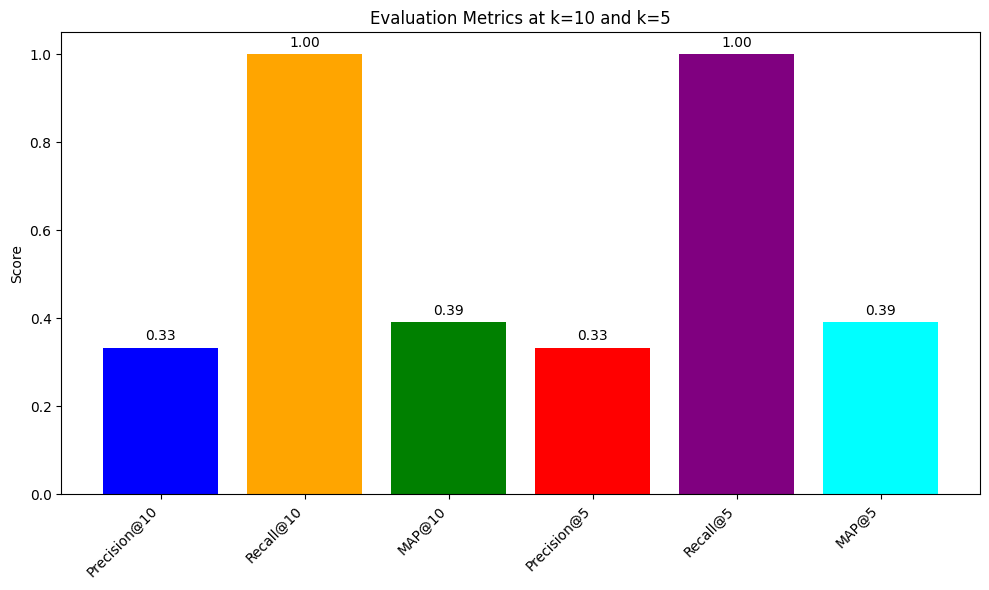

In [95]:

import numpy as np
from sklearn.metrics import precision_score, recall_score, average_precision_score

def calculate_metrics_at_k(y_true, y_pred_probs, k):
    """
    Calculates Precision@k, Recall@k, and MAP@k.

    Args:
        y_true: True labels (one-hot encoded).
        y_pred_probs: Predicted probabilities.
        k: The value of k for metrics calculation.

    Returns:
        A tuple containing Precision@k, Recall@k, and MAP@k.
    """
    # Get top k predictions
    top_k_indices = np.argsort(y_pred_probs, axis=1)[:, -k:]

    # Convert probabilities to class predictions (top k)
    y_pred_top_k = np.zeros_like(y_true)
    for i, indices in enumerate(top_k_indices):
        y_pred_top_k[i, indices] = 1

    # Calculate metrics
    precision_at_k = precision_score(y_true, y_pred_top_k, average='macro')
    recall_at_k = recall_score(y_true, y_pred_top_k, average='macro')
    map_at_k = average_precision_score(y_true, y_pred_probs, average='macro')

    return precision_at_k, recall_at_k, map_at_k

# Assuming you have y_test (true labels) and y_pred_probs (predicted probabilities)
# ... (your existing code for model training and prediction)

# Calculate metrics at k=10 and k=5
precision_at_10, recall_at_10, map_at_10 = calculate_metrics_at_k(y_test, y_pred_probs, k=10)
precision_at_5, recall_at_5, map_at_5 = calculate_metrics_at_k(y_test, y_pred_probs, k=5)

# Print the results
print(f"Precision@10: {precision_at_10:.2f}")
print(f"Recall@10: {recall_at_10:.2f}")
print(f"MAP@10: {map_at_10:.2f}")
print(f"Precision@5: {precision_at_5:.2f}")
print(f"Recall@5: {recall_at_5:.2f}")
print(f"MAP@5: {map_at_5:.2f}")

# Data for the bar chart
metrics = ['Precision@10', 'Recall@10', 'MAP@10', 'Precision@5', 'Recall@5', 'MAP@5']
values = [precision_at_10, recall_at_10, map_at_10, precision_at_5, recall_at_5, map_at_5]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red', 'purple', 'cyan'])
plt.title('Evaluation Metrics at k=10 and k=5')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')

# Add value labels to the bars
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

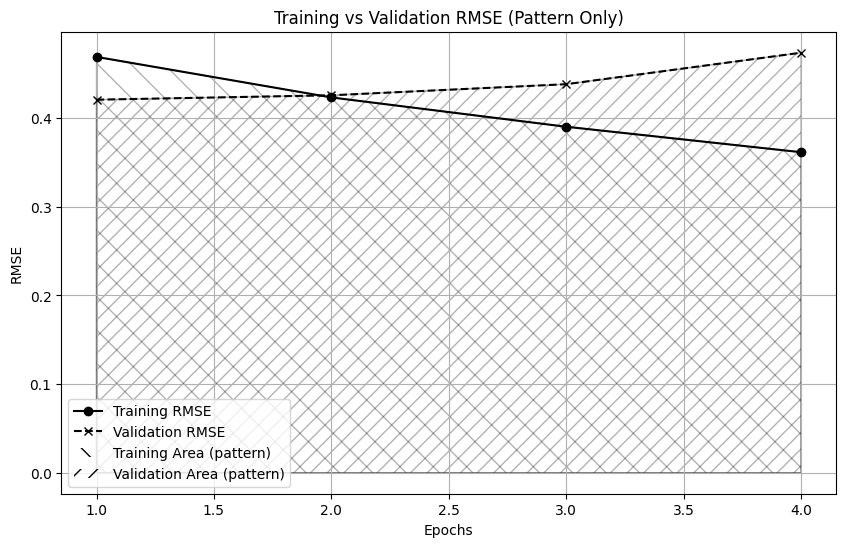

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you want to plot RMSE against epochs
# Replace 'epochs' with the actual number of epochs or a range
epochs = range(1, len(history.history['loss']) + 1)

# Replace train_errors and val_errors with actual RMSE values
# You'll need to calculate these based on your model's predictions and true labels
# For example:
# train_errors = [calculate_rmse(y_train, model.predict(X_train)) for i in epochs]
# val_errors = [calculate_rmse(y_val, model.predict(X_val)) for i in epochs]

# Placeholder for RMSE values - replace with your actual calculations
train_errors = history.history['loss']  # Assuming 'loss' is RMSE
val_errors = history.history['val_loss']  # Assuming 'val_loss' is RMSE

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_errors, label="Training RMSE", linestyle='-', marker='o', color='black')
plt.plot(epochs, val_errors, label="Validation RMSE", linestyle='--', marker='x', color='black')

plt.fill_between(epochs, train_errors, alpha=0.3, label="Training Area (pattern)", facecolor='none', hatch='\\')
plt.fill_between(epochs, val_errors, alpha=0.3, label="Validation Area (pattern)", facecolor='none', hatch='//')

plt.title("Training vs Validation RMSE (Pattern Only)")
plt.xlabel("Epochs")  # Changed from "Number of Latent Factors"
plt.ylabel("RMSE")
plt.legend()
plt.grid()
plt.show()